# 4.2c - Selections with high and low entropy

In [1]:
import os
import sys
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.2c-byentropy'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [4]:
def CLD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(256, (16,), strides=16)(last)
    last = LSTM(128)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

# Create models

In [5]:
cats = rawset.categories
tsets, vsets = rawset.rnd_split_fraction_by_category(0.5)
tsets = tsets.by_category()
vsets = vsets.by_category()

In [14]:
cats = ['pps', 'ppt', 'gz', 'png', 'dwf', 'swf', 'pptx', 'kmz', 'jpg', 'pdf', 'eps', 'ps', 
        'f', 'txt', 'gif', 'html', 'xml', 'doc', 'xls', 'sql', 'hlp', 'log', 'kml', 'java', 
        'csv', 'wp', 'rtf', 'dbase3']

In [7]:
if os.path.exists(result_dir + "/high.tsv"):
    os.remove(result_dir + "/high.tsv")
r = report.Reporter2(result_dir + '/high.tsv')
for i in range(2,len(cats)+1):
    mycats = cats[:i]
    myset = rawset.filter(lambda x: rawset.category_from(x) in mycats)
    myset.rebuild_categories()
    tset, vset = myset.rnd_split_fraction_by_category(0.5)

    model = CLD(len(mycats), 256)
    print(len(mycats), mycats)
    result = Trainer(
        model,
        xs_encoder='one_hot',
        batch_size=100,
        steps_per_epoch=28,
        validation_steps=28,
        patience=10,
    ).train(tset, vset)
#     h5_path = os.path.join(result_dir, '%s_%s.h5' % (cats[i], cats[j]))
#     model.save(h5_path)
    print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])
    r.line(n=i,
           elapsed=result.elapsed,
           **report.report_epochs(**result._asdict()),
           **report.report_metrics(**result._asdict()),
          )
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2 ['pps', 'ppt']
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
294.87442350387573 0.5114286
3 ['pps', 'ppt', 'gz']
790.0546114444733 0.46357143
4 ['pps', 'ppt', 'gz', 'png']
471.6037254333496 0.37892857
5 ['pps', 'ppt', 'gz', 'png', 'dwf']
719.2105782032013 0.34464285
6 ['pps', 'ppt', 'gz', 'png', 'dwf', 'swf']
312.2630088329315 0.30071428
7 ['pps', 'ppt', 'gz', 'png', 'dwf', 'swf', 'pptx']
558.0394012928009 0.27035713
8 ['pps', 'ppt', 'gz', 'png', 'dwf', 'swf', 'pptx', 'kmz']
701.0954613685608 0.28321427
9 ['pps', 'ppt', 'gz', 'png', 'dwf', 'swf', 'pptx', 'kmz', 'jpg']
851.0924706459045 0.29964286
10 ['pps', 'ppt', 'gz', 'png', 'dwf', 'swf', 'pptx', 'kmz', 'jpg', 'pdf']
578.0746586322784 0.31607142
11 ['pps', 'ppt', 'gz', 'png', 'dwf', 'swf', 'pptx', 'kmz', 'jpg', 'pdf', 'eps']
519.0848009586334 0.34785715
12 ['pps', 'ppt

# Load results

In [8]:
data = pd.read_csv(result_dir + '/high.tsv', sep='\t')
data

,n,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,2,294.874424,11,0.511429,0.511429
1,3,790.054611,37,0.675952,0.463571
2,4,471.603725,26,0.752679,0.378929
3,5,719.210578,48,0.796214,0.344643
4,6,312.263009,17,0.842024,0.300714
5,7,558.039401,24,0.863724,0.270357
6,8,701.095461,34,0.883080,0.283214
7,9,851.092471,46,0.896984,0.299643
8,10,578.074659,31,0.908857,0.316071
9,11,519.084801,29,0.921851,0.347857


In [15]:
cats.reverse()
cats

['dbase3',
 'rtf',
 'wp',
 'csv',
 'java',
 'kml',
 'log',
 'hlp',
 'sql',
 'xls',
 'doc',
 'xml',
 'html',
 'gif',
 'txt',
 'f',
 'ps',
 'eps',
 'pdf',
 'jpg',
 'kmz',
 'pptx',
 'swf',
 'dwf',
 'png',
 'gz',
 'ppt',
 'pps']

In [16]:
if os.path.exists(result_dir + "/low.tsv"):
    os.remove(result_dir + "/low.tsv")
r = report.Reporter2(result_dir + '/low.tsv')
for i in range(2,len(cats)+1):
    mycats = cats[:i]
    myset = rawset.filter(lambda x: rawset.category_from(x) in mycats)
    myset.rebuild_categories()
    tset, vset = myset.rnd_split_fraction_by_category(0.5)

    model = CLD(len(mycats), 256)
    print(len(mycats), mycats)
    result = Trainer(
        model,
        xs_encoder='one_hot',
        batch_size=100,
        steps_per_epoch=28,
        validation_steps=28,
        patience=10,
    ).train(tset, vset)
#     h5_path = os.path.join(result_dir, '%s_%s.h5' % (cats[i], cats[j]))
#     model.save(h5_path)
    print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])
    r.line(n=i,
           elapsed=result.elapsed,
           **report.report_epochs(**result._asdict()),
           **report.report_metrics(**result._asdict()),
          )
r.close()

2 ['dbase3', 'rtf']
300.18683385849 0.9992857
3 ['dbase3', 'rtf', 'wp']
548.5413782596588 0.98285717
4 ['dbase3', 'rtf', 'wp', 'csv']
308.6714072227478 0.9628571
5 ['dbase3', 'rtf', 'wp', 'csv', 'java']
407.2665047645569 0.9710714
6 ['dbase3', 'rtf', 'wp', 'csv', 'java', 'kml']
422.4532277584076 0.9525
7 ['dbase3', 'rtf', 'wp', 'csv', 'java', 'kml', 'log']
612.8797447681427 0.9635714
8 ['dbase3', 'rtf', 'wp', 'csv', 'java', 'kml', 'log', 'hlp']
484.53121280670166 0.9425
9 ['dbase3', 'rtf', 'wp', 'csv', 'java', 'kml', 'log', 'hlp', 'sql']
252.97677302360535 0.91642857
10 ['dbase3', 'rtf', 'wp', 'csv', 'java', 'kml', 'log', 'hlp', 'sql', 'xls']
623.3340802192688 0.92321426
11 ['dbase3', 'rtf', 'wp', 'csv', 'java', 'kml', 'log', 'hlp', 'sql', 'xls', 'doc']
1152.69362282753 0.9121429
12 ['dbase3', 'rtf', 'wp', 'csv', 'java', 'kml', 'log', 'hlp', 'sql', 'xls', 'doc', 'xml']
559.6656692028046 0.8625
13 ['dbase3', 'rtf', 'wp', 'csv', 'java', 'kml', 'log', 'hlp', 'sql', 'xls', 'doc', 'xml', 'h

# Load results

In [17]:
data = pd.read_csv(result_dir + '/low.tsv', sep='\t')
data

,n,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,2,300.186834,19,0.999286,0.999286
1,3,548.541378,36,0.988571,0.982857
2,4,308.671407,21,0.981071,0.962857
3,5,407.266505,26,0.988714,0.971071
4,6,422.453228,27,0.985238,0.952500
5,7,612.879745,40,0.990102,0.963571
6,8,484.531213,32,0.985759,0.942500
7,9,252.976773,17,0.981627,0.916429
8,10,623.334080,42,0.985143,0.923214
9,11,1152.693623,75,0.984188,0.912143


# Add pairs of classes to graph 4.2b

In [18]:
data42a = pd.read_csv('results/4.2a-nclasses/nclasses.tsv', sep='\t')
data42b = pd.read_csv('results/4.2b-pairs/nclasses.tsv', sep='\t')
data42c = pd.read_csv('results/4.2c-byentropy/high.tsv', sep='\t')
data42d = pd.read_csv('results/4.2c-byentropy/low.tsv', sep='\t')
mdata = pd.concat([data42a, data42b, data42c])

/home/atila.alr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [19]:
from matplotlib.ticker import MultipleLocator
def plot_acc(xs, ys, labels=None, loc='upper right', alpha_on=None):
    fig = plt.figure(figsize=(12,8))
#     fig.yaxis.set_minor_locator()
    if labels is None:
        labels = [None for x in xs]
    for x, y, label, mark in zip(xs, ys, labels, ['g-', '-ms', '-yD', 'bx']):
        plt.plot(x[x==alpha_on], y[x==alpha_on], mark, alpha=0.1, label='')
        plt.plot(x[x!=alpha_on], y[x!=alpha_on], mark, label=label)
    ax1 = plt.gca()
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of classes', fontsize=16)
    plt.xlim((-0, 31))
    plt.ylim((-0, 1.2))
    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(linestyle='-', color='k', which='major')
    plt.grid(linestyle='--', which='minor')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.legend(loc=loc, prop={'size': 16})
#     plt.savefig('acc.png')

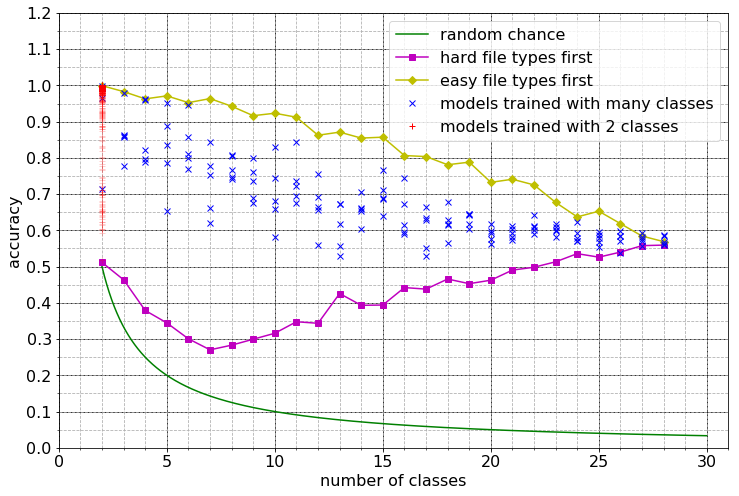

In [21]:
x = np.arange(2,30,0.01)
y = 1/x
plot_acc([x,
          data42c['n'],
          data42d['n'],
          data42a['n'], 
         ], 
         [y,
          data42c['val_categorical_accuracy'],
          data42d['val_categorical_accuracy'],
          data42a['val_categorical_accuracy'], 
         ], 
         ['random chance', 
          'hard file types first',
          'easy file types first',
          'models trained with many classes', 
         ])
plt.plot(data42b['n'], data42b['val_categorical_accuracy'], 'r+', alpha=0.2, label='models trained with 2 classes')
leg = plt.legend(loc='upper right', prop={'size': 16})
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
